<center><h1>- Indeed Job Ads (India July 2022) -</h1></center>

This dataset contains approximately 1600 job information records. The jobs are mainly related to:
 - Data Engineer
 - Data Analyst
 - Data Scientist
 - ML engineer

There are eight columns in this dataset:
- Job Title
- Company name
- Job summary
- Job Location
- Expected Salary
- Post Date
- Today
- URL

> **Goal:** to clean and analyse the dataset, extract the most in demand skills, investigate how the jobs are disributed geographically and how salary is distributed across different job roles.

### Libraries

In [1]:
# Libraries
import pandas as pd
import numpy as np
import re

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Custom colors
class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
#print(clr.S+"Notebook Color Scheme:"+clr.E)

# 1. Load & Inspect Data
**There are 1583 datapoints and 8 columns, with a small amount of missing data**

> `job_salary` is missing 1178 values which means gaining any useful insight into salary information is going to be difficult

In [3]:
df = pd.read_csv('../input/data-science-data-analyst-and-ml-job-indeed/job_dataset.csv')
df.sample(5, random_state=22)

job_title  \
1334                            Data Governance Analyst   
125                                      Data Scientist   
1043  Immediate requirement for Data Analytics - WFO...   
1397                              Data Insights Analyst   
575   Senior Program Manager - Computer Vision Embed...   

                                              company          job_location  \
1334                                            Crowe  Noida, Uttar Pradesh   
125                                       Aganitha AI  Hyderabad, Telangana   
1043        Talent Corner HR Services Private Limited   Mumbai, Maharashtra   
1397                  The Economist Newspaper Limited      Gurgaon, Haryana   
575   Mercedes-Benz Research and Development India...  Bengaluru, Karnataka   

                                            job_summary  \
1334  Participate in the application and deployment ...   
125   Deep learning and classical ML methods.,Modula...   
1043  Solve the data problem at scale.,In addition t...   
1397  Experience working with data from multiple dat...   
575   This role is to build, lead, manage team & wor...   

                      post_date       today                    job_salary  \
1334         Posted30+ days ago  2022-07-26                           NaN   
125           Posted25 days ago  2022-07-26                           NaN   
1043  EmployerActive 3 days ago  2022-07-26  ₹3,00,000 - ₹8,00,000 a year   
1397         Posted30+ days ago  2022-07-26                           NaN   
575           Posted19 days ago  2022-07-26                           NaN   

                                                job_url  
1334  https://in.indeed.com/rc/clk?jk=6a7a8ee4c2259a...  
125   https://in.indeed.com/rc/clk?jk=6fa51d6dab10e2...  
1043  https://in.indeed.com/company/Talent-Corner-HR...  
1397  https://in.indeed.com/rc/clk?jk=604b26701cb083...  
575   https://in.indeed.com/rc/clk?jk=7f68152e35c54b...

In [4]:
df.shape # rows and columns

(1583, 8)

In [5]:
df.dtypes # imported data types

job_title       object
company         object
job_location    object
job_summary     object
post_date       object
today           object
job_salary      object
job_url         object
dtype: object

In [6]:
# Missing values for each column
df.isna().sum()

job_title          0
company            0
job_location       0
job_summary        0
post_date          0
today              0
job_salary      1178
job_url            0
dtype: int64

## Column: `today`
Only has **one** unique value: 26/07/2022

Hence, will mark that to be removed upon data cleaning

In [7]:
df.today.astype('str').nunique()

1

## Column: `post_date`

There are 4 different regex pattterns:
- Posted[\d] days ago (e.g. Posted4 days ago)
- PostedPosted [\d] days ago (e.g. PostedPosted 4 days ago)
- EmployerActive [\d] days ago (e.g. EmployerActive 4 days ago)
- Hiring ongoing

So can clean up as two additional columns:
- days_ago_job_posted
- days_ago_employer_active

Replacing 30+ days with 31

In [8]:
df.post_date[df.post_date.str.contains('Posted[\d].*', regex=True)]

30      Posted30+ days ago
31      Posted30+ days ago
32        Posted4 days ago
33      Posted30+ days ago
34      Posted30+ days ago
               ...        
1562    Posted30+ days ago
1563     Posted27 days ago
1564    Posted30+ days ago
1566    Posted30+ days ago
1567      Posted7 days ago
Name: post_date, Length: 940, dtype: object

In [9]:
df.post_date[df.post_date.str.contains('Posted[\D].*', regex=True)]

0       PostedPosted 30+ days ago
1       PostedPosted 30+ days ago
2         PostedPosted 3 days ago
3       PostedPosted 30+ days ago
4       PostedPosted 30+ days ago
                  ...            
1576    PostedPosted 30+ days ago
1577     PostedPosted 13 days ago
1578      PostedPosted 6 days ago
1580     PostedPosted 20 days ago
1581     PostedPosted 18 days ago
Name: post_date, Length: 384, dtype: object

In [10]:
df.post_date[df.post_date.str.contains('Employer.*')]

5        EmployerActive 5 days ago
12       EmployerActive 3 days ago
14       EmployerActive 5 days ago
41       EmployerActive 4 days ago
46       EmployerActive 4 days ago
                   ...            
1558     EmployerActive 4 days ago
1565     EmployerActive 3 days ago
1568     EmployerActive 5 days ago
1579     EmployerActive 4 days ago
1582    EmployerActive 19 days ago
Name: post_date, Length: 240, dtype: object

In [11]:
df.post_date[~(df.post_date.str.contains('Posted.*') | df.post_date.str.contains('Employer.*'))]

37      Hiring ongoing
40      Hiring ongoing
177     Hiring ongoing
230     Hiring ongoing
250     Hiring ongoing
327     Hiring ongoing
419     Hiring ongoing
543     Hiring ongoing
623     Hiring ongoing
731     Hiring ongoing
789     Hiring ongoing
851     Hiring ongoing
922     Hiring ongoing
1013    Hiring ongoing
1071    Hiring ongoing
1163    Hiring ongoing
1246    Hiring ongoing
1261    Hiring ongoing
1287    Hiring ongoing
Name: post_date, dtype: object

In [12]:
mask = (df.post_date.astype('str').str.contains('Posted.*')) &  (~df.post_date.astype('str').str.contains('PostedPosted.*'))
df.post_date.astype('str')[mask].str.extract('[\D]*(?P<num>[\d]*)', expand=False)
# df

8         
25        
30      30
31      30
32       4
        ..
1562    30
1563    27
1564    30
1566    30
1567     7
Name: num, Length: 1058, dtype: object

In [13]:
df.post_date[(df.post_date.str.contains('Posted.*') | df.post_date.str.contains('Employer.*') | df.post_date.str.contains('Hiring.*'))].count() - df.post_date.count()

0

In [14]:
df.post_date.astype('str').str.replace('30\+', '31', regex=True)

0         PostedPosted 31 days ago
1         PostedPosted 31 days ago
2          PostedPosted 3 days ago
3         PostedPosted 31 days ago
4         PostedPosted 31 days ago
                   ...            
1578       PostedPosted 6 days ago
1579     EmployerActive 4 days ago
1580      PostedPosted 20 days ago
1581      PostedPosted 18 days ago
1582    EmployerActive 19 days ago
Name: post_date, Length: 1583, dtype: object

## Column: `job_salary`

Job salary is either a singular value or a numerical range. In addition, some values are quoted per year and others per month.

Hence, going to extract two new columns of salary min and max with both values quoted per year.

In [15]:
df.job_salary.astype('str').str.extractall('\D*(\d+[,\d+]*)').unstack().loc[:, (0, 0)].str.replace(',','').astype('int')

5         80045
7       1800000
12      1500000
16       250000
23        12086
         ...   
1576     300000
1579      20000
1580     600000
1581     800000
1582     300000
Name: (0, 0), Length: 405, dtype: int64

In [16]:
df.job_salary.astype('str').str.extract('\sa (\D+)', expand=False).replace({'month':'12', 'year': '1'}).astype('float')

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1578     NaN
1579    12.0
1580     1.0
1581     1.0
1582     1.0
Name: job_salary, Length: 1583, dtype: float64

## Column: `company`

I'm going to convert to a categorical value with any company less than 6 value counts being treated as `Other`

In [17]:
df.company.value_counts()[df.company.value_counts() > 5]

Deloitte                                            45
Mercedes-Benz Research and Development India...     20
Oracle                                              20
Accenture                                           18
JPMorgan Chase Bank, N.A.                           16
FENG GROUP                                          16
EY                                                  16
IBM                                                 16
Standard Chartered                                  15
McKinsey & Company                                  13
Barclays                                            13
Bosch Group                                         12
Unisys                                              11
Infosys Limited                                     11
Google                                              10
NatWest Group                                       10
BlueOptima                                           9
MasterCard                                           8
PwC       

In [18]:
def generate_categories_greater_than_n(df, n):
    vcs = df.value_counts()
    top_categories = vcs[vcs>n].index
    return df.where(df.isin(top_categories),'Other').astype('category')

generate_categories_greater_than_n(df.company, 5).value_counts()

Other                                               1221
Deloitte                                              45
Mercedes-Benz Research and Development India...       20
Oracle                                                20
Accenture                                             18
FENG GROUP                                            16
JPMorgan Chase Bank, N.A.                             16
IBM                                                   16
EY                                                    16
Standard Chartered                                    15
Barclays                                              13
McKinsey & Company                                    13
Bosch Group                                           12
Infosys Limited                                       11
Unisys                                                11
Google                                                10
NatWest Group                                         10
BlueOptima                     

## Column: `job_location`

Pull out the state which is the first part of the location before the comma.

Sometimes the output of this has `Remote in` substring so pull out the location after this.

Clean up the few oddities after both these rules

Can also create a boolean column of remote which is present in a lot of `job_location`'s

In [19]:
df.job_location.value_counts()[df.job_location.value_counts() > 2] # Need a bool column of remote

Bengaluru, Karnataka                          478
Gurgaon, Haryana                              110
Hyderabad, Telangana                          106
Pune, Maharashtra                              78
Mumbai, Maharashtra                            59
Remote                                         58
Bengaluru, Karnataka+1 location                51
India                                          49
Noida, Uttar Pradesh                           48
Remote in Bengaluru, Karnataka                 43
Chennai, Tamil Nadu                            43
Delhi, Delhi                                   42
New Delhi, Delhi                               25
Remote in Hyderabad, Telangana                 17
Kolkata, West Bengal                           15
Navi Mumbai, Maharashtra                       12
Gurgaon, Haryana+1 location                    10
Ahmedabad, Gujarat                             10
Indore, Madhya Pradesh                         10
Temporarily Remote in Bengaluru, Karnataka     10


In [20]:
df.job_location[df.job_location.astype('str').str.extract('.*, ([A-Za-z ]*)', expand=False).isna()].value_counts()

Remote                         58
India                          49
Remote in India                 9
+1 locationRemote               5
Maharashtra                     4
Temporarily Remote              2
Remote in Delhi                 1
Hybrid remote in India          1
Telangana+1 location            1
Andaman and Nicobar Islands     1
Temporarily Remote in Delhi     1
Haryana                         1
Name: job_location, dtype: int64

In [21]:
def tweak_location(df):
    df_temp = df.where(df.astype('str').str.extract('.*, ([A-Za-z ]*)', expand=False).isna(), 
                    df.astype('str').str.extract('.*, ([A-Za-z ]*)', expand=False))
    return (df_temp.where(df_temp.astype('str').str.extract('.*in (\w*)', expand=False).isna(),
                    df_temp.astype('str').str.extract('.*in (\w*)', expand=False))
                .replace({'+1 locationRemote': 'Remote', 'Temporarily Remote': 'Remote', 'Telangana+1 location': 'Telangana'}))

tweak_location(df.job_location).value_counts()

Karnataka                      606
Maharashtra                    217
Haryana                        141
Telangana                      141
Delhi                           91
Uttar Pradesh                   72
Remote                          65
Tamil Nadu                      65
India                           59
West Bengal                     24
Gujarat                         23
Kerala                          21
Madhya Pradesh                  12
Punjab                          10
Bihar                            9
Chandigarh                       8
Rajasthan                        7
Andhra Pradesh                   4
Uttarakhand                      2
Chhattisgarh                     2
Orissa                           2
Assam                            1
Andaman and Nicobar Islands      1
Name: job_location, dtype: int64

## Column: `job_title`

I am going to split the job title into one or more categories:
- Data Science (`DS`)
- Data Analyst (`DA`)
- Data Engineer (`DE`)
- Business Analyst (`BA`)
- ML Engineer (`ml_eng`)
- Computer Vision Engineer (`cv_eng`)
- Software Engineer (`sw_eng`)
- Quality Assurance (`QA`)
- Cloud Engineer (`cloud`)
- Deep Learning (`DL`)
- NLP (`NLP`)
- Data Architect (`data_architect`)
- Research Roles (`research`)
- Management Roles (`management`)

I have done this by concatenating a number of possible `str.contains()` statements for each role to see if any match for the raw `job_title` field. There are some job titles that match multiple categories, such as Data Scientist & Machine Learning Engineer.

There is also the possibility to extract boolean columns seniority/level attributes:
- Junior
- Senior
- Intern

In [22]:
df.job_title.astype('string').str.replace('[\W]', ' ', regex=True).str.split(' +', expand=True).where(~df.job_title.astype('string').str.replace('[\W]', ' ', regex=True).str.split(' +', expand=True).isna(), '')

0            1        2            3         4        5   \
0      Technology         Lead     Data      Science         I  Machine   
1        Software     Engineer  Machine     Learning                      
2     Experienced         Over      The     Shoulder  Mechanic      C17   
3            Data    Scientist                                            
4          Python    Developer                                            
...           ...          ...      ...          ...       ...      ...   
1578     Learning  Integration  Analyst       Senior   Analyst            
1579     Business      Analyst                                            
1580     Research      Analyst  Central       Events    Hybrid            
1581      Program     Research  Analyst  Sustainable    Cities      and   
1582         Data      Analyst                                            

             6  7  8  9  10  
0      Learning              
1                            
2                            
3                            
4                            
...         ... .. .. .. ..  
1578                         
1579                         
1580                         
1581  Transport              
1582                         

[1583 rows x 11 columns]

In [23]:
roles = ['Data Analyst', 'Business Analyst', 'Machine Learning', 'Data Engineer', 'Computer Vision Engineer', 'Data Science', 'Data Scientist',
         'Software Engineer', 'Data Analytics', 'Java Developer', 'Power BI Developer', 'ML Engineer', 'Full Stack Developer', 'Research Analyst',
         'Quality Analyst', 'Data Architect', 'Python Developer', 'Cloud Engineer', 'Computer Vision', 'Data Analysis', 'Deep Learning', 'ML', 'NLP',
         'Python', 'Tester', 'Cloud', 'Data Artitect', 'QA', 'Data Governance', 'Data & Analytics Analyst', 'Data Management Analyst']

df.job_title[~df.job_title.astype('string').str.contains(('.*' + '|'.join(roles)), regex=True, flags=re.IGNORECASE)]
roles_dict = {'DS': ['Data Science', 'Data Scientist'], 'DA': ['Data Analyst', 'Data Analytics', 'Power BI', 'Data Analysis', 'Data & Analytics Analyst', 'BI Analyst', 'Power-Bi'],
              'DE': ['Data Engineer'], 'BA': ['Business Analyst'], 'ml_eng': ['Machine Learning', 'ML Engineer', 'ML'],
              'cv_eng': ['Computer Vision Engineer', 'Computer Vision', 'Computer Vison'],
              'sw_eng': ['Software Engineer', 'Java Developer', 'Full Stack Developer', 'Python Developer', 'Python', 'Tester', 'Developer'], 
              'QA': ['Quality Analyst', 'QA', 'Software Quality', 'Quality Assurance'], 'cloud': ['Cloud Engineer', 'Cloud'], 'DL': ['Deep Learning'], 'NLP': ['NLP'], 
              'data_architect': ['Data Architect', 'Data Artitect'], 'research': ['Research'], 'management': ['Data Governance', 'Data Management Analyst']}
df_roles = pd.DataFrame({key: df.job_title.astype('string').str.contains('|'.join(value), regex=True, flags=re.IGNORECASE).values for (key, value) in roles_dict.items()})
df_roles
# df.job_title[~df_roles.any(axis=1)][360:]
# df.job_title.astype('string').str.contains('|'.join(roles_dict['DS'])).values

DS     DA     DE     BA  ml_eng  cv_eng  sw_eng     QA  cloud     DL  \
0      True  False  False  False    True   False   False  False  False  False   
1     False  False  False  False    True   False    True  False  False  False   
2     False  False  False  False   False   False   False  False  False  False   
3      True  False  False  False   False   False   False  False  False  False   
4     False  False  False  False   False   False    True  False  False  False   
...     ...    ...    ...    ...     ...     ...     ...    ...    ...    ...   
1578  False  False  False  False   False   False   False  False  False  False   
1579  False  False  False   True   False   False   False  False  False  False   
1580  False  False  False  False   False   False   False  False  False  False   
1581  False  False  False  False   False   False   False  False  False  False   
1582  False   True  False  False   False   False   False  False  False  False   

        NLP  data_architect  research  management  
0     False           False     False       False  
1     False           False     False       False  
2     False           False     False       False  
3     False           False     False       False  
4     False           False     False       False  
...     ...             ...       ...         ...  
1578  False           False     False       False  
1579  False           False     False       False  
1580  False           False      True       False  
1581  False           False      True       False  
1582  False           False     False       False  

[1583 rows x 14 columns]

In [24]:
# extract column for contains Senior/Sr, Junior, Intern
df.job_title[df.job_title.astype('string').str.contains('.*Senior|.*Sr\.', regex=True, flags=re.IGNORECASE)]
df.job_title[df.job_title.astype('string').str.contains('.*intern', regex=True, flags=re.IGNORECASE)]

11               Software Engineering Intern, Winter 2023
23                                Machine Learning Intern
84                 Machine Learning Intern - (Final Year)
90                              Intern - Business Analyst
181                              Machine Learning Interns
199                           Data Engineering Internship
219                      Machine Learning Intern, Core ML
226                                 Data Science - Intern
249     Data Science Internship Opportunity for Univer...
253     Software Engineering Internship Opportunity fo...
258              Software Engineering Intern, Winter 2023
259                                 Data Science - Intern
272                                   Data Science Intern
273                                   Data Science Intern
281                               Data science internship
288                                   Data Analyst Intern
309                                   Data Science Intern
547           

## Column: `job_summary`

Job summary column is a bit rubbish as the description is limited to the first ~160 characters.

In [25]:
fdist0 = FreqDist(word.lower() for word in word_tokenize(df.job_summary[0]))
fdist0
# fdist0.plot(50, cumulative=True)

FreqDist({'the': 3, 'of': 2, ',': 2, 'a': 1, 'day': 1, 'in': 1, 'life': 1, 'an': 1, 'infoscion': 1, '•': 1, ...})

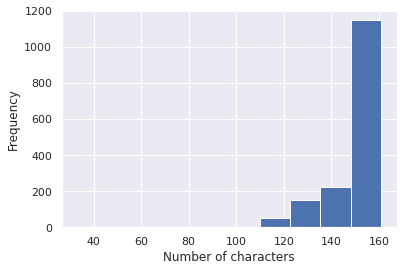

In [26]:
ax = df.job_summary.map(len).plot.hist()
ax.set_xlabel('Number of characters');

In [27]:
len(df.job_summary.str.cat(sep=' '))

239571

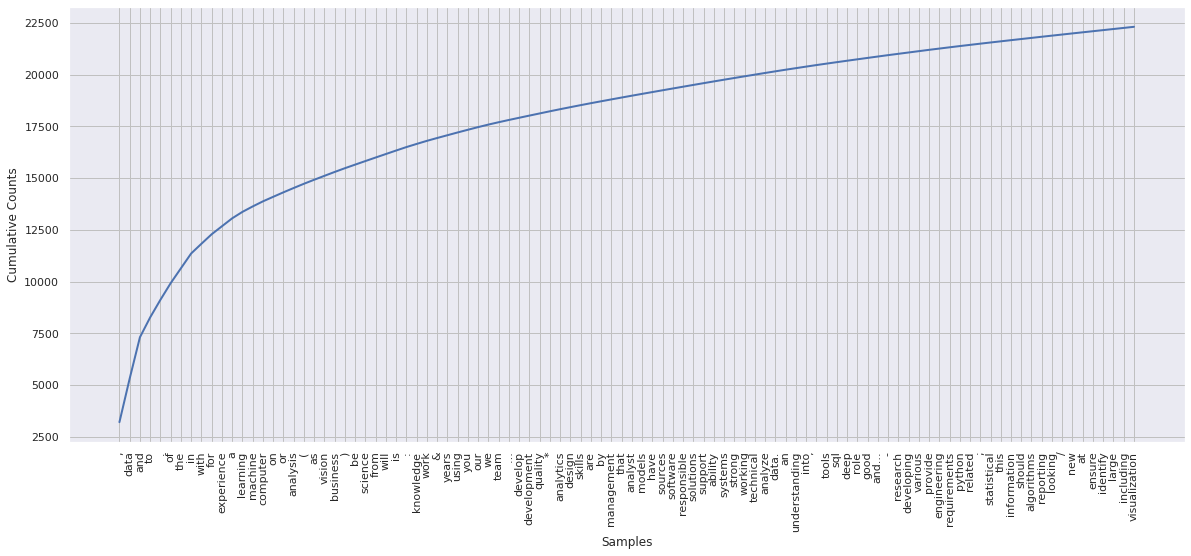

In [28]:
fig, ax = plt.subplots(figsize=(20,8))
fdist_whole = FreqDist(word.lower() for word in word_tokenize( df.job_summary.str.cat(sep=' ') ))
fdist_whole.plot(100, cumulative=True);

# 2. Clean Data

Put all of the above together into a data cleaning pipeline `tweak_data`

In [29]:
def tweak_data(df):
    
    def days_ago_job_posted(df):
        posted_mask = df.astype('str').str.contains('Posted.*')
        return (df.astype('str')
                .where(~posted_mask, df.str.replace('30\+', '31', regex=True).str.extract('[\D]*([\d]*)', expand=False))
                .where(posted_mask, np.nan)
                .str.replace('^$', '0', regex=True).astype('float')
           )
    
    def days_ago_employer_active(df):
        employer_active_mask = df.astype('str').str.contains('Employer.*')
        return (df.astype('str')
                .where(~employer_active_mask, df.str.replace('30\+', '31', regex=True).str.extract('[\D]*([\d]*)', expand=False))
                .where(employer_active_mask, np.nan).astype('float')
           )
    
    def get_min_salary(df):
        
        multiplier = (df.astype('str')
                      .str.extract('\sa (\D+)', expand=False)
                      .replace({'month':'12', 'year': '1'}).astype('float'))
        
        return (df
                .astype('str')
                .str.extractall('\D*(\d+[,\d+]*)')
                .unstack().loc[:, (0, 0)]
                .str.replace(',','')
                .astype('int')
                .mul(multiplier))
    
    def get_max_salary(df):
        
        multiplier = (df.astype('str')
                      .str.extract('\sa (\D+)', expand=False)
                      .replace({'month':'12', 'year': '1'}).astype('float'))
        
        return (df
               .astype('str')
               .str.extractall('\D*(\d+[,\d+]*)')
               .unstack().loc[:,(0, 1)]
               .str.replace(',','')
               .astype('float')
               .mul(multiplier))
    
    def generate_categories_greater_than_n(df, n):
        vcs = df.value_counts()
        top_categories = vcs[vcs>n].index
        return df.where(df.isin(top_categories),'Other').astype('category')
    
    def tweak_location(df):
        df_temp = df.where(df.astype('str').str.extract('.*, ([A-Za-z ]*)', expand=False).isna(), 
                        df.astype('str').str.extract('.*, ([A-Za-z ]*)', expand=False))
        return (df_temp.where(df_temp.astype('str').str.extract('.*in (\w*)', expand=False).isna(),
                        df_temp.astype('str').str.extract('.*in (\w*)', expand=False))
                    .replace({'+1 locationRemote': 'Remote', 'Temporarily Remote': 'Remote', 'Telangana+1 location': 'Telangana'})
               .astype('string'))
    
    def tweak_roles(df):
#         print(df.columns)
        roles_dict = {'DS': ['Data Science', 'Data Scientist'], 'DA': ['Data Analyst', 'Data Analytics', 'Power BI',
                                                                       'Data Analysis', 'Data & Analytics Analyst', 'BI Analyst', 'Power-Bi'],
                      'DE': ['Data Engineer'], 'BA': ['Business Analyst'], 'ml_eng': ['Machine Learning', 'ML Engineer', 'ML'],
                      'cv_eng': ['Computer Vision Engineer', 'Computer Vision', 'Computer Vison'],
                      'sw_eng': ['Software Engineer', 'Java Developer', 'Full Stack Developer',
                                 'Python Developer', 'Python', 'Tester', 'Developer'], 
                      'QA': ['Quality Analyst', 'QA', 'Software Quality', 'Quality Assurance'], 'cloud': ['Cloud Engineer', 'Cloud'], 
                      'DL': ['Deep Learning'], 'NLP': ['NLP'], 
                      'data_architect': ['Data Architect', 'Data Artitect'], 'research': ['Research'], 
                      'management': ['Data Governance', 'Data Management Analyst']}
        
        return df.join(pd.DataFrame({key: df.job_title.astype('string').str.contains('|'.join(value), regex=True, flags=re.IGNORECASE).values
                                     for (key, value) in roles_dict.items()}))
        
    
    return (df
            .assign(days_ago_job_posted=lambda df_: days_ago_job_posted(df_.post_date),
                    days_ago_employer_active=lambda df_: days_ago_employer_active(df_.post_date),
                    min_salary = lambda df_: get_min_salary(df_.job_salary),
                    max_salary = lambda df_: get_max_salary(df_.job_salary))
            .assign(max_salary = lambda df_: df_.max_salary.where( (~df_.max_salary.isna()) & (df_.max_salary > df_.min_salary), other=df_.min_salary),
                   company = lambda df_: generate_categories_greater_than_n(df_.company, 5),
                   remote = lambda df_: df_.job_location.astype('str').str.contains('.*[Rr]emote.*'),
                   location = lambda df_: tweak_location(df_.job_location))
            .pipe(tweak_roles)
            .assign(senior = lambda df_: df_.job_title.astype('string').str.contains('.*Senior|.*Sr\.', regex=True, flags=re.IGNORECASE),
                       junior = lambda df_:df_.job_title.astype('string').str.contains('.*junior', regex=True, flags=re.IGNORECASE),
                       intern = lambda df_: df_.job_title.astype('string').str.contains('.*intern', regex=True, flags = re.IGNORECASE))
            .drop(columns=['today', 'post_date'])
           )
tweak_df = tweak_data(df)
tweak_df

job_title          company  \
0     Technology Lead : Data Science I Machine Learning  Infosys Limited   
1                   Software Engineer, Machine Learning           Google   
2           Experienced Over The Shoulder Mechanic- C17            Other   
3                                        Data Scientist  Infosys Limited   
4                                      Python Developer  Infosys Limited   
...                                                 ...              ...   
1578        Learning Integration-Analyst/Senior Analyst         Deloitte   
1579                                   Business Analyst            Other   
1580         Research Analyst - Central Events (Hybrid)            Other   
1581  Program Research Analyst – Sustainable Cities ...            Other   
1582                                       Data Analyst            Other   

                                job_location  \
0                       Bengaluru, Karnataka   
1                       Bengaluru, Karnataka   
2     Remote in Air Force Station, Karnataka   
3                       Bengaluru, Karnataka   
4                       Bengaluru, Karnataka   
...                                      ...   
1578                    Bengaluru, Karnataka   
1579                  Lucknow, Uttar Pradesh   
1580                    Bengaluru, Karnataka   
1581                     Mumbai, Maharashtra   
1582                       Jaipur, Rajasthan   

                                            job_summary  \
0     A day in the life of an Infoscion • As part of...   
1     2 years of relevant work experience in machine...   
2     This position will focus on supporting the Boe...   
3     Anchor ML development track in a client projec...   
4     Should have a decent understanding of the Mach...   
...                                                 ...   
1578  Experience with data visualization software su...   
1579  Lead efforts to gather and analyze data requir...   
1580  Linking millions of assured data points, Janes...   
1581  Design and implement quantitative and qualitat...   
1582  Analyze website data to determine areas of sit...   

                        job_salary  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   
...                            ...   
1578                           NaN   
1579               ₹20,000 a month   
1580              ₹6,00,000 a year   
1581  ₹8,00,000 - ₹9,00,000 a year   
1582  ₹3,00,000 - ₹6,00,000 a year   

                                                job_url  days_ago_job_posted  \
0     https://in.indeed.com/pagead/clk?mo=r&ad=-6NYl...                 31.0   
1     https://in.indeed.com/pagead/clk?mo=r&ad=-6NYl...                 31.0   
2     https://in.indeed.com/pagead/clk?mo=r&ad=-6NYl...                  3.0   
3     https://in.indeed.com/pagead/clk?mo=r&ad=-6NYl...                 31.0   
4     https://in.indeed.com/pagead/clk?mo=r&ad=-6NYl...                 31.0   
...                                                 ...                  ...   
1578  https://in.indeed.com/rc/clk?jk=6b93b48dc96688...                  6.0   
1579  https://in.indeed.com/company/Shri-Ramswaroop-...                  NaN   
1580  https://in.indeed.com/company/Janes/jobs/Resea...                 20.0   
1581  https://in.indeed.com/rc/clk?jk=9dfb216af07f4f...                 18.0   
1582  https://in.indeed.com/company/Angara-E--Commer...                  NaN   

      days_ago_employer_active  min_salary  max_salary  ...     QA  cloud  \
0                          NaN         NaN         NaN  ...  False  False   
1                          NaN         NaN         NaN  ...  False  False   
2                          NaN         NaN         NaN  ...  False  False   
3                          NaN         NaN         NaN  ...  False  False   
4                          NaN         NaN  

In [30]:
tweak_df.dtypes

job_title                     object
company                     category
job_location                  object
job_summary                   object
job_salary                    object
job_url                       object
days_ago_job_posted          float64
days_ago_employer_active     float64
min_salary                   float64
max_salary                   float64
remote                          bool
location                      string
DS                           boolean
DA                           boolean
DE                           boolean
BA                           boolean
ml_eng                       boolean
cv_eng                       boolean
sw_eng                       boolean
QA                           boolean
cloud                        boolean
DL                           boolean
NLP                          boolean
data_architect               boolean
research                     boolean
management                   boolean
senior                       boolean
j

# 3. Visualise the data

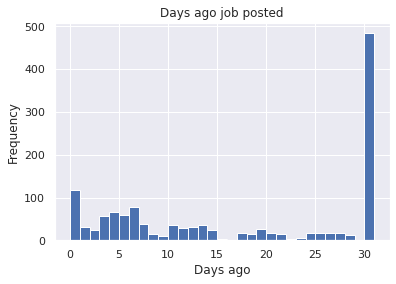

In [31]:
ax = tweak_df.days_ago_job_posted.plot.hist(bins=31, title='Days ago job posted')
ax.set_xlabel('Days ago');

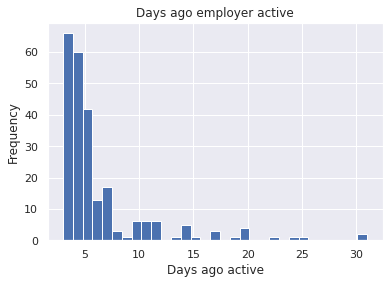

In [32]:
ax = tweak_df.days_ago_employer_active.plot.hist(bins=31, title='Days ago employer active')
ax.set_xlabel('Days ago active');

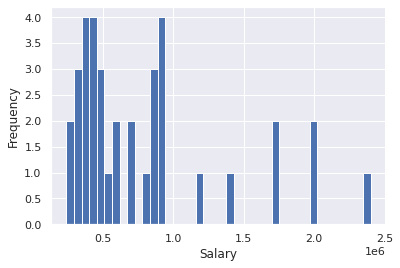

In [33]:
ax = tweak_df[tweak_df.BA].loc[:, ['min_salary', 'max_salary']].mean(axis=1).plot.hist(bins=40)
ax.set_xlabel('Salary');